In [1]:
enter_name = "Todsavad Tangtortan"

In [2]:
# !pip install datasets

## Recommendation: Use Google Colab

In [3]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import random

import torch.nn.functional as F
import torch, torchdata, torchtext
from torch import nn
import time
import os

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 2422
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


cuda:2


# Load CNN/DM dataset from huggingface (10 points)

In [4]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Found cached dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [6]:
## Load the train data and the validation data
train_data = dataset['train']
valid_data = dataset['validation']

# Convert the dataset into pandas DataFrame with proper column names

In [7]:
df_train = pd.DataFrame(train_data)
df_valid = pd.DataFrame(valid_data)

In [8]:
df_train.shape, df_valid.shape

((287113, 3), (13368, 3))

In [9]:
df_train.drop(columns=['id'],inplace=True)
df_valid.drop(columns=['id'],inplace=True)

In [10]:
df_train.shape, df_valid.shape

((287113, 2), (13368, 2))

### The training dataset is too big use only 1000 sample maximum
### You can reduce the validation dataset as well accordingly

In [11]:
#code here
df_train = df_train[:1000]
df_valid = df_valid[:100]

In [12]:
df_train.shape, df_valid.shape

((1000, 2), (1000, 2))

# Preprocessing (20 points)
- analyze the data
- lowercase everything
- remove unnecessary words that would not make sense
- remove linebreaks and backslashes 


In [13]:
#Your code here....
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re

nlp = spacy.load('en_core_web_sm')

def preprocessing(sentence):

    # sentence = re.sub('[^a-zA-Z]', '', str(sentence))
    # sentence = re.sub("<[^>]*>", "", str(sentence))
    stopwords = list(STOP_WORDS)

    doc = nlp(sentence)

    cleaned_tokens = []

    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
    
    return " ".join(cleaned_tokens)

In [14]:
SRC_LANGUAGE = 'article'
TRG_LANGUAGE = 'highlights'
# Place-holders
token_transform = {}
vocab_transform = {}

In [15]:
from torchtext.data.utils import get_tokenizer

# tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [16]:
# token_transform[SRC_LANGUAGE](df_train['article'][0])
# token_transform[TRG_LANGUAGE](df_train['highlights'][0])

In [17]:
def yield_tokens(data_iter, language):
    global ts
    #complete this code
    # helper function to yield list of tokens
    # here data can be `train` or `val` or `test`
    # language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}
    if language_index[language] == 0:
        ts = SRC_LANGUAGE
    if language_index[language] == 1:
        ts = TRG_LANGUAGE
    print(ts)
    for data_sample in data_iter[ts]:
        yield token_transform[language](data_sample) #either first or second index

In [18]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [19]:
# from torchtext.vocab import build_vocab_from_iterator

# vocab_transform  = build_vocab_from_iterator(yield_tokens(df_train['article']), min_freq=2, special_first=True, specials=special_symbols) #takes 9minutes
# vocab_transform.set_default_index(UNK_IDX)

In [20]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(df_train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

article
highlights


In [21]:
vocab_transform

{'article': Vocab(), 'highlights': Vocab()}

In [22]:
print('Vocab Size SRC_LANGUAGE',len(vocab_transform[SRC_LANGUAGE]))                         
print(vocab_transform[SRC_LANGUAGE].get_itos())   

Vocab Size SRC_LANGUAGE 19973
['<unk>', '<pad>', '<sos>', '<eos>', ',', 'the', '.', 'to', '"', 'of', 'and', 'a', 'in', "'s", 'said', '-', 'that', 'for', 'was', 'is', 'The', 'on', 'with', 'he', 'I', '--', 'it', 'as', 'his', 'have', 'from', 'at', 'are', 'has', 'by', 'be', 'not', 'were', 'an', 'this', 'CNN', 'who', 'her', 'had', '(', ')', 'they', 'but', 'been', 'about', 'she', 'their', 'will', 'you', "n't", 'people', 'or', 'we', 'after', ' ', ':', 'would', 'one', 'He', 'more', 'It', 'which', 'out', 'up', 'when', 'two', 'do', 'U.S.', 'also', "'", 'year', 'told', 'than', 'A', 'there', 'its', 'all', 'In', 'what', 'into', 'can', 'time', '»', 'other', 'We', 'But', 'them', 'friend', 'over', 'first', 'some', 'mail', 'my', 'years', 'him', 'could', 'government', 'just', 'Iraq', 'no', 'last', 'says', 'E', 'Obama', 'like', 'did', '?', 'so', 'Watch', 'police', 'because', 'report', '$', 'if', 'before', 'our', 'United', 'Clinton', 'where', 'three', 'according', 'against', 'being', 'country', 'any', 'me

In [23]:
print('Vocab Size TRG_LANGUAGE',len(vocab_transform[TRG_LANGUAGE]))                         
print(vocab_transform[TRG_LANGUAGE].get_itos())   

Vocab Size TRG_LANGUAGE 4488
['<unk>', '<pad>', '<sos>', '<eos>', '.', '\n', ',', 'to', 'in', 'of', '"', 'the', "'s", '-', ':', 'a', 'says', 'and', 'for', 'on', 'is', 'was', 'with', 'NEW', 'from', 'at', 'The', 'U.S.', 'has', 'as', 'by', 'say', 'he', 'after', 'are', 'have', 'will', 'be', 'not', 'that', 'his', 'were', 'people', 'Obama', 'year', 'two', 'her', 'it', 'Iraq', ';', 'an', 'been', 'first', 'over', 'had', 'one', '$', 'I', "n't", 'killed', 'police', 'about', 'into', 'she', 'Clinton', 'than', 'said', 'up', 'President', 'also', 'Bush', 'last', 'more', 'years', 'who', 'found', 'out', 'but', 'their', "'", 'He', 'they', 'CNN', 'Police', '1', 'Sen.', 'death', 'this', 'can', 'children', 'no', 'president', 'three', 'could', 'government', 'official', 'million', 'New', 'off', 'or', 'other', 'percent', 'when', 'died', 'officials', 'day', 'new', 'time', 'against', 'since', 'old', '3', 'family', 'help', 'military', '2', 'charges', 'A', 'five', 'him', 'home', 'four', 'calls', 'troops', 'week',

In [24]:
import pickle
with open('vocab_transform_cnn.pickle', 'wb') as f:
    pickle.dump(vocab_transform, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('vocab_transform_cnn.pickle', 'rb') as f:
    vocab_transform = pickle.load(f)

In [25]:
# mapping = vocab_transform.get_itos()
# mapping[200]

##  FastText Embedding

In [26]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') ##Load fasttext with language=simple

In [27]:
fast_embedding_src = fast_vectors.get_vecs_by_tokens(vocab_transform[SRC_LANGUAGE].get_itos()).to(device)
fast_embedding_trg = fast_vectors.get_vecs_by_tokens(vocab_transform[TRG_LANGUAGE].get_itos()).to(device)

In [28]:
fast_embedding_src.shape, fast_embedding_trg.shape 

(torch.Size([19973, 300]), torch.Size([4488, 300]))

In [29]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE = 5
# BATCH_SIZE = 64

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func


def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                        torch.tensor(token_ids),
                        torch.tensor([EOS_IDX])))


# text_transform = {}

# text_transform = sequencetial_transforms(tokenizer,
#                                            vocab_transform,
#                                             tensor_transform)

text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [30]:
class DataWrap(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [31]:
train = DataWrap(df_train)
valid = DataWrap(df_valid)

In [32]:
batch_size = 5
# batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                             collate_fn=collate_batch) 

In [33]:
for art, _, high in train_loader:
    print(art.shape)
    print(high.shape)
    break

torch.Size([1123, 5])
torch.Size([58, 5])


# Create a model  (35 points)
- Create a Seq2Seq attention model  
- It should be a Bi-GRU model with 2 layers  **(5 points)**
- The Attention shoud be ScaledDotProduct not Additive **(20 points)**
- The main model must take "target" as optional. So that we dont have to pass target in inference. Also include max summary length, teacher forcing etc. **(10 points)**


In [34]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

In [35]:
class DotAttention(nn.Module):
    def __init__(self, hid_dim, variants = 'Additive'):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'ScaledDotProduct': 
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, src len, hid dim]
            
            scale = hidden.size(-1) ** 0.5 #dk

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2)) #hi @ s
            #energy = [batch size, 1, src len]

            attention = energy.squeeze(1)/scale #hi @ s / dk
            #attention = [batch size, src len]

            #use masked_fill_ if you want in-place
            attention = attention.masked_fill(mask, -1e10)

        elif self.variants == 'Additive': 
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]

            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))

            #energy = [batch size, src len, hid dim]

            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]

            #use masked_fill_ if you want in-place
            attention = attention.masked_fill(mask, -1e10)
            
        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [36]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [37]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important
        
        

In [38]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

## Quick Note: Apply the fasttext embedding to the model

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
#Create train function here
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [41]:
#create evaluate function here
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [42]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [43]:
train_loader_length, val_loader_length

(200, 20)

### Additive

In [44]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])

emb_dim     = 300 #fasttext
hid_dim     = 512  
dropout     = 0.5

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
SRC_PAD_IDX = PAD_IDX

attn = DotAttention(hid_dim, variants='Additive')

enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
enc.embedding.weight.data = fast_embedding_src #**<------applied the fast text embedding as the initial weights
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)
dec.embedding.weight.data = fast_embedding_trg #**<------applied the fast text embedding as the initial weights

model = Seq2SeqModel(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

cuda:2


Seq2SeqModel(
  (encoder): Encoder(
    (embedding): Embedding(19973, 300)
    (rnn): GRU(300, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): DotAttention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(4488, 300)
    (gru): GRU(1324, 512)
    (fc): Linear(in_features=1836, out_features=4488, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [45]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5991900
460800
786432
  1536
  1536
460800
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1346400
2033664
786432
  1536
  1536
8239968
  4488
______
22219300


In [46]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

- Train you mode for 5- 10 epochs (10 epochs should take 25 minutes in google colab)
- Save your model in name format (YourName_nlp_quiz2.pt) **(5 points)**
- Be sure to submit your model in google classroom

In [47]:
import time
import math
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}_Additive.pt' #Change here

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 1m 20s
	Train Loss: 6.645 | Train PPL: 769.240
	 Val. Loss: 5.514 |  Val. PPL: 248.091
Epoch: 02 | Time: 1m 25s
	Train Loss: 5.960 | Train PPL: 387.625
	 Val. Loss: 5.480 |  Val. PPL: 239.822
Epoch: 03 | Time: 1m 24s
	Train Loss: 5.715 | Train PPL: 303.384
	 Val. Loss: 5.492 |  Val. PPL: 242.828


KeyboardInterrupt: 

#### Plot the losses

Text(0, 0.5, 'loss')

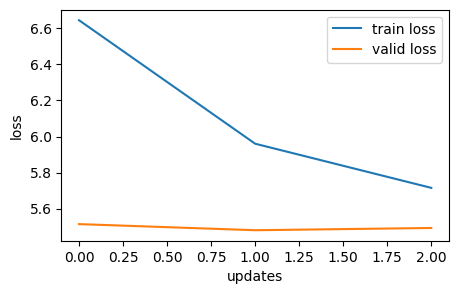

In [48]:
#code here
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

### ScaledDotProduct

In [49]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])

emb_dim     = 300 #fasttext
hid_dim     = 512  
dropout     = 0.5

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)
SRC_PAD_IDX = PAD_IDX

attn = DotAttention(hid_dim, variants='ScaledDotProduct')

enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
enc.embedding.weight.data = fast_embedding_src #**<------applied the fast text embedding as the initial weights
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)
dec.embedding.weight.data = fast_embedding_trg #**<------applied the fast text embedding as the initial weights

model = Seq2SeqModel(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

cuda:2


Seq2SeqModel(
  (encoder): Encoder(
    (embedding): Embedding(19973, 300)
    (rnn): GRU(300, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): DotAttention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(4488, 300)
    (gru): GRU(1324, 512)
    (fc): Linear(in_features=1836, out_features=4488, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [50]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5991900
460800
786432
  1536
  1536
460800
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1346400
2033664
786432
  1536
  1536
8239968
  4488
______
22219300


In [51]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

- Train you mode for 5- 10 epochs (10 epochs should take 25 minutes in google colab)
- Save your model in name format (YourName_nlp_quiz2.pt) **(5 points)**
- Be sure to submit your model in google classroom

In [52]:
import time
import math
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}_ScaledDotProduct.pt' #Change here

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 55s
	Train Loss: 6.601 | Train PPL: 735.720
	 Val. Loss: 5.595 |  Val. PPL: 269.103
Epoch: 02 | Time: 0m 52s
	Train Loss: 5.959 | Train PPL: 387.108
	 Val. Loss: 5.498 |  Val. PPL: 244.163
Epoch: 03 | Time: 0m 49s
	Train Loss: 5.687 | Train PPL: 294.955
	 Val. Loss: 5.464 |  Val. PPL: 235.944
Epoch: 04 | Time: 0m 48s
	Train Loss: 5.436 | Train PPL: 229.588
	 Val. Loss: 5.561 |  Val. PPL: 260.101
Epoch: 05 | Time: 0m 53s
	Train Loss: 5.146 | Train PPL: 171.741
	 Val. Loss: 5.542 |  Val. PPL: 255.296


#### Plot the losses

Text(0, 0.5, 'loss')

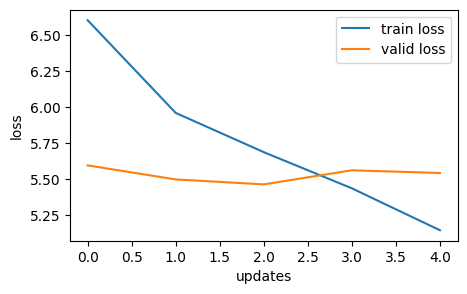

In [53]:
#code here
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## Finally we can summarize (25 points)
- Summarize the given sample 
- The max length of summary should be 15 tokens
- Select the top 4 summaries generated from the model


In [54]:
#code here
max_len = 15
sample = "Mrs Kopta, who has dementia, has been living in a nursing home after she was taken in as a person in need seven years after she disappeared. + It's a relief she hasn't been murdered. Her husband Bob Kopta said he had been married to Mrs Kopta for 20 years before she went missing. He said: It's a relief knowing that she's not laying in a ditch somewhere, or murdered somewhere. The 86-year-old added that his family suspected she may be in Puerto Rico but she was declared dead around 25 years ago. The retired electrician also said he had consulted with a psychic about her whereabouts. Mrs Kopta has two sisters - a twin, who died six years ago, and a younger sister who was relieved to learn she's still alive, Mr Kopta added. He said he has experienced a range of emotions over the years but is content knowing his wife is alive and being cared for. After 30 years, you try to forget about it. Now I can forget about it. We know what happened, and she is taken care of now, he said."

In [55]:
src_text = text_transform[SRC_LANGUAGE](sample).to(device)
target = "It is fake target"*20
trg_text = text_transform[TRG_LANGUAGE](target).to(device)
trg_text = trg_text.reshape(-1, 1)
src_text = src_text.reshape(-1, 1)  #because batch_size is 1
print('src_text and trg_text shape',src_text.shape, trg_text.shape)
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing
    #trg_len, batch_size, trg_output_dim
    output = output.squeeze(1)
    #trg_len, trg_output_dim
    output = output[1:]
    output_max = output.argmax(1) #returns max indices
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()

    predict_setence = []
    for token in output_max:
        if mapping[token.item()] == '<eos>':
            sum =  ' '.join(predict_setence)
        
        predict_setence.append(mapping[token.item()])

    sum = ' '.join(predict_setence)

src_text and trg_text shape torch.Size([219, 1]) torch.Size([63, 1])


In [56]:
sum

'<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . \n <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . \n <unk> <unk>'

### Conclusion **(5 points)**
- How did the model perform?
    - I dind't train 5-10 but only 1 epoch, it show differnt 
    - the model give better perplexity and faster if using ScaledDotProduct 

- Does using the FastText Embedding improve the performance? 
    - Yes it improve performance because 
        1. bigger embedding size (300) from orignal embedding size (256)
        2. vectors capture hidden information
        
- How does ScaledDotProduct Attention perform compared to the Additive attention?

    ScaledDotProduct Attention
    
    $\text{Attention}(Q,K,V)=\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$

    Addtive Attention : ( $d_3$ is a hyperparameter )

    $e_i = v^t tanh ( \textbf{W}_1 h_i + \textbf{W}_2 s) \in \mathbb{R} ; $
    Even Additive will give higher accuracy but it is TOO slow (differet around 30 second per epoch)
    
    Mostly, ScaledDotProduct is slightly same as DotProduct which is not only fast because of multiplication matrix but also scaled normalize which result why it is faster than Additive attention
    
- What do you suggest we can do to increase the performance in text summarization?

    - Preprocessing tokenizer carefully
    - Using Transformer, BART 
    - Fine-tune specifical data


In [ ]:
#answer here